In [1]:
# Summer 2021 Internship project with Oak Ride National Laboratory (ORNL)
# Code Written By: Arjun Viswanathan
# Mentored By: Dr. Junqi Yin
# Date Started: 6/7/2021
# Date TBC: 8/13/2021
# All datasets provided by Dr. Yin

import h5py
import numpy as np
from matplotlib import pyplot as plt
import time
from tensorflow import keras
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.cm as cmx
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, UpSampling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input, Model

In [2]:
print(str(time.ctime()) + ": Initializing...")
sarsmerscov_train = h5py.File('/ccs/proj/gen150/arjun2612/ORNL/datasets/sars-mers-cov2_train.h5', 'r')
sarsmerscov_val = h5py.File('/ccs/proj/gen150/arjun2612/ORNL/datasets/sars-mers-cov2_val.h5', 'r')
lt = list(open('/ccs/proj/gen150/arjun2612/ORNL/txtFiles/label_train.txt', 'r'))
lv = list(open('/ccs/proj/gen150/arjun2612/ORNL/txtFiles/label_val.txt', 'r')) # open all files
cvae_embeddings = np.load('/gpfs/alpine/gen150/scratch/arjun2612/ORNL_Coding/Code/cvae/sars-mers-cov2-embeddings.npy', 'r')
cvae_samples = np.load('/gpfs/alpine/gen150/scratch/arjun2612/ORNL_Coding/Code/cvae/sars-mers-cov2-samples.npz', 'r')

label_training = np.array([])
label_validation = np.array([])

train_size = 60000 # 10% of the datasets
val_size = 15000

for i in range(train_size):
    num = int(str(lt[i]).strip('\n'))
    label_training = np.append(label_training, num)
    
for j in range(val_size):
    num = int(str(lv[j]).strip('\n'))
    label_validation = np.append(label_validation, num)

trainset = np.array(sarsmerscov_train['contact_maps'][0:train_size]).astype(float) # 60000 x 24 x 24 x 1
valset = np.array(sarsmerscov_val['contact_maps'][0:val_size]).astype(float) # 15000 x 24 x 24 x 1

trainset, label_training = shuffle(trainset, label_training, random_state=0)
valset, label_validation = shuffle(valset, label_validation, random_state=0)

train_3D = np.tril(trainset[:, :, :, 0])
val_3D = np.tril(valset[:, :, :, 0])

lt_onehot = to_categorical(label_training) # make one hot vectors
lv_onehot = to_categorical(label_validation)

cvae_embeddings = np.squeeze(cvae_embeddings)[0:val_size]

lt = None
lv = None
sarsmerscov_train = None
sarsmerscov_val = None # garbage collection to free up memory

print(str(time.ctime()) + ": Successfully loaded all data sets!")

Fri Jun 18 10:13:38 2021: Initializing...
Fri Jun 18 10:13:39 2021: Successfully loaded all data sets!


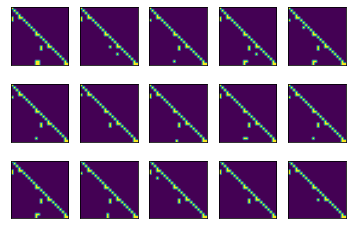

In [3]:
plt.figure(1)
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_3D[i, :, :])
plt.show()

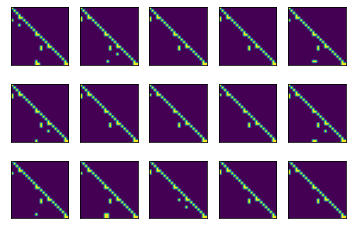

In [4]:
plt.figure(2)
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(val_3D[i, :, :])
plt.show()

In [5]:
print(str(time.ctime()) + ": Implementing PCA Clustering...")

train_pca = np.reshape(train_3D, (train_3D.shape[0], -1))  # 60000 x 576
val_pca = np.reshape(val_3D, (val_3D.shape[0], -1))  # 15000 x 576

normalized_train_pca = normalize(train_pca, axis=1, norm='l1')
normalized_val_pca = normalize(val_pca, axis=1, norm='l1')

# sc = StandardScaler()
# normalized_train_pca = sc.fit_transform(train_pca)
# normalized_val_pca = sc.fit_transform(val_pca)

pca = PCA(2)  # 2 PCs
pca.fit(normalized_train_pca)
reduced_train = pca.transform(normalized_train_pca)
reduced_val = pca.transform(normalized_val_pca) # reduce dimensions of both sets

print('Total explained variance: {}'.format(pca.explained_variance_ratio_.sum() * 100))

print(str(time.ctime()) + ": Finished PCA Clustering!")

Fri Jun 18 10:13:40 2021: Implementing PCA Clustering...
Total explained variance: 49.78138346235961
Fri Jun 18 10:13:42 2021: Finished PCA Clustering!


In [6]:
print(str(time.ctime()) + ": Implementing PCA ML...")

batch_size = 64
epochs = 20

pcamodel = Sequential()
pcamodel.add(Dense(128, activation='relu', input_shape=(2,)))
pcamodel.add(Dense(64, activation='relu'))
pcamodel.add(Dense(64, activation='relu'))
pcamodel.add(Dense(32, activation='relu'))
pcamodel.add(Dense(3, activation='softmax'))

early_stop = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)
pcamodel.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['categorical_accuracy'])
history = pcamodel.fit(reduced_train, lt_onehot, batch_size=batch_size, epochs=epochs, validation_data=(reduced_val, lv_onehot), callbacks=[early_stop])

print(str(time.ctime()) + ": Finished PCA ML")

Fri Jun 18 10:13:42 2021: Implementing PCA ML...
Epoch 1/20
938/938 [==============================] - 2s 2ms/step - loss: 0.6785 - categorical_accuracy: 0.6210 - val_loss: 0.5299 - val_categorical_accuracy: 0.6937
Epoch 2/20
938/938 [==============================] - 1s 1ms/step - loss: 0.5350 - categorical_accuracy: 0.6869 - val_loss: 0.5282 - val_categorical_accuracy: 0.6943
Epoch 3/20
938/938 [==============================] - 1s 1ms/step - loss: 0.5243 - categorical_accuracy: 0.6924 - val_loss: 0.5129 - val_categorical_accuracy: 0.6916
Epoch 4/20
938/938 [==============================] - 1s 1ms/step - loss: 0.5140 - categorical_accuracy: 0.6983 - val_loss: 0.5085 - val_categorical_accuracy: 0.6823
Epoch 5/20
938/938 [==============================] - 1s 1ms/step - loss: 0.5048 - categorical_accuracy: 0.6985 - val_loss: 0.4910 - val_categorical_accuracy: 0.7011
Epoch 6/20
938/938 [==============================] - 1s 1ms/step - loss: 0.4945 - categorical_accuracy: 0.6997 - val_los

In [7]:
print(str(time.ctime()) + ": Predicting with PCA Model...")

result = pcamodel.predict(reduced_val)
result = np.argmax(np.round(result), axis=1)

print(str(time.ctime()) + ": Finished predictions!")

Fri Jun 18 10:14:09 2021: Predicting with PCA Model...
Fri Jun 18 10:14:09 2021: Finished predictions!


In [8]:
correct = np.where(result == label_validation)[0]
incorrect = np.where(result != label_validation)[0]
print("Number of Correct Classifications: {}".format(len(correct)))
print("Number of Incorrect Classifications: {}".format(len(incorrect)))
print("Total Accuracy: {}".format((len(correct) / len(label_validation)) * 100))

Number of Correct Classifications: 10785
Number of Incorrect Classifications: 4215
Total Accuracy: 71.89999999999999


In [9]:
print(str(time.ctime()) + ": Implementing K-Means Clustering...")
km = KMeans(n_clusters=3, random_state=0)
km.fit(train_pca)
labels_val = np.array(km.predict(val_pca))

accuracy = (sum(labels_val == label_validation) / len(label_validation)) * 100

print('Accuracy: {}'.format(accuracy))
print(str(time.ctime()) + ": Finished K-Means Clustering!")

Fri Jun 18 10:14:09 2021: Implementing K-Means Clustering...
Accuracy: 66.12666666666667
Fri Jun 18 10:14:12 2021: Finished K-Means Clustering!


In [10]:
train_X, valid_X, train_label, valid_label = train_test_split(trainset, lt_onehot, test_size=0.2, random_state=0)
# train_X = samples x 24 x 24 x 1
# valid_X = samples x 24 x 24 x 1
# train_label = samples x 3
# valid_label = samples x 3

In [11]:
print(str(time.ctime()) + ": Creating Classification Model...")

x = Input(shape=(24, 24, 1))  # 24 x 24 x 1

# Encoder
e_conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(x) # 24 x 24 x 8
pool1 = MaxPool2D((2, 2), padding='same')(e_conv1) # 12 x 12 x 8
b_norm1 = BatchNormalization()(pool1)

e_conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(b_norm1) # 12 x 12 x 16
pool2 = MaxPool2D((2, 2), padding='same')(e_conv2) # 6 x 6 x 16
b_norm2 = BatchNormalization()(pool2)

e_conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(b_norm2) # 6 x 6 x 32
pool3 = MaxPool2D((2, 2), padding='same')(e_conv3) # 3 x 3 x 32
b_norm3 = BatchNormalization()(pool3)

e_conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(b_norm3) # 3 x 3 x 64
b_norm4 = BatchNormalization()(e_conv4)

e_conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(b_norm4) # 3 x 3 x 128
b_norm5 = BatchNormalization()(e_conv5)

# Decoder
d_conv1 = Conv2D(128, (3, 3), activation='relu', padding='same')(b_norm5) # 3 x 3 x 128
up1 = UpSampling2D((2, 2))(d_conv1) # 6 x 6 x 128
b_norm6 = BatchNormalization()(up1)

d_conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(b_norm6) # 6 x 6 x 64
up2 = UpSampling2D((2, 2))(d_conv2) # 12 x 12 x 64
b_norm7 = BatchNormalization()(up2)

d_conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(b_norm7) # 12 x 12 x 32
up3 = UpSampling2D((2, 2))(d_conv3) # 24 x 24 x 32
b_norm8 = BatchNormalization()(up3)

d_conv4 = Conv2D(16, (3, 3), activation='relu', padding='same')(b_norm8) # 24 x 24 x 16
b_norm9 = BatchNormalization()(d_conv4)

d_conv5 = Conv2D(8, (3, 3), activation='relu', padding='same')(b_norm9) # 24 x 24 x 8
b_norm10 = BatchNormalization()(d_conv5)

d_conv6 = Conv2D(1, (1, 1), activation='relu', padding='same')(b_norm10) # 24 x 24 x 1
b_norm11 = BatchNormalization()(d_conv6)

f1 = Flatten()(b_norm11) # add a fully connected layer after just the autoencoder. 576 x 1
r = Dense(3, activation='softmax')(f1) # 3 x 1

classification_model = Model(x, r) # compile full model
classification_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='Adam', metrics=['categorical_accuracy'])

print(str(time.ctime()) + ": Successfully created Classification Model")

Fri Jun 18 10:14:12 2021: Creating Classification Model...
Fri Jun 18 10:14:12 2021: Successfully created Classification Model


In [12]:
print(str(time.ctime()) + ": Training Classification Model...")

epochs = 20
batch_size = 64
early_stop = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)
classify_labels = classification_model.fit(train_X, train_label, batch_size=batch_size, epochs=epochs, callbacks=[early_stop], validation_data=(valid_X, valid_label))

print(str(time.ctime()) + ": Finished training!")

Fri Jun 18 10:14:12 2021: Training Classification Model...
Epoch 1/20
750/750 [==============================] - 6s 5ms/step - loss: 0.4986 - categorical_accuracy: 0.7033 - val_loss: 0.4274 - val_categorical_accuracy: 0.7421
Epoch 2/20
750/750 [==============================] - 4s 5ms/step - loss: 0.4308 - categorical_accuracy: 0.7310 - val_loss: 0.4229 - val_categorical_accuracy: 0.7498
Epoch 3/20
750/750 [==============================] - 4s 5ms/step - loss: 0.4304 - categorical_accuracy: 0.7331 - val_loss: 0.4274 - val_categorical_accuracy: 0.7433
Epoch 4/20
750/750 [==============================] - 4s 5ms/step - loss: 0.4311 - categorical_accuracy: 0.7365 - val_loss: 0.4226 - val_categorical_accuracy: 0.7469
Epoch 5/20
750/750 [==============================] - 4s 5ms/step - loss: 0.4329 - categorical_accuracy: 0.7365 - val_loss: 0.4573 - val_categorical_accuracy: 0.7233
Epoch 6/20
750/750 [==============================] - 4s 5ms/step - loss: 0.4337 - categorical_accuracy: 0.7278

In [13]:
print(str(time.ctime()) + ": Evaluating Classification Model...")

test_eval = classification_model.evaluate(valid_X, valid_label)
print('Loss: {}'.format(test_eval[0]))
print('Accuracy: {}'.format(test_eval[1] * 100))

print(str(time.ctime()) + ": Finished evaluation!")

Fri Jun 18 10:14:41 2021: Evaluating Classification Model...
375/375 [==============================] - 1s 2ms/step - loss: 0.4229 - categorical_accuracy: 0.7498
Loss: 0.42290064692497253
Accuracy: 74.9750018119812
Fri Jun 18 10:14:42 2021: Finished evaluation!


In [14]:
print(str(time.ctime()) + ": Predicting with Classification Model...")

predicted = classification_model.predict(valset)
predicted = np.argmax(np.round(predicted), axis=1)

print(str(time.ctime()) + ": Finished predictions!")

Fri Jun 18 10:14:42 2021: Predicting with Classification Model...
Fri Jun 18 10:14:43 2021: Finished predictions!


In [15]:
correct = np.where(predicted == label_validation)[0]
incorrect = np.where(predicted != label_validation)[0]
print("Number of Correct Classifications: " + str(len(correct)))
print("Number of Incorrect Classifications: " + str(len(incorrect)))

Number of Correct Classifications: 11058
Number of Incorrect Classifications: 3942


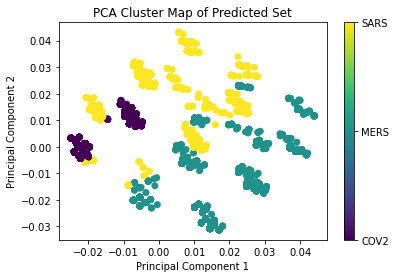

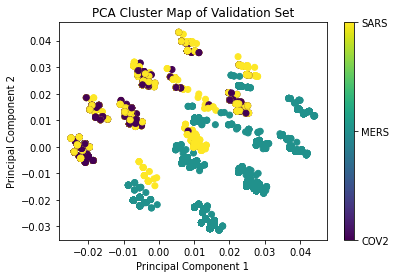

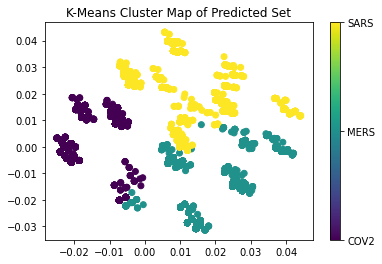

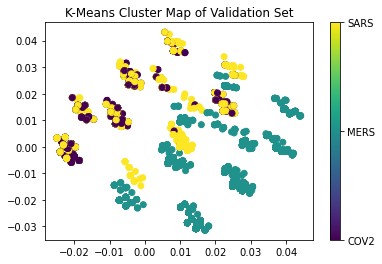

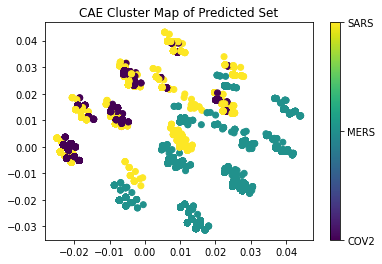

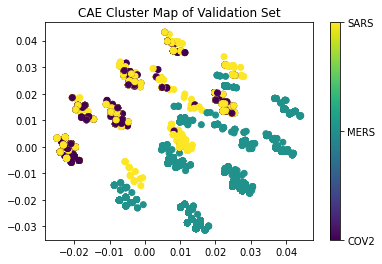

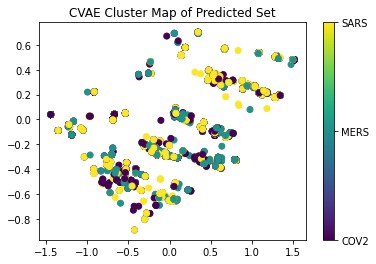

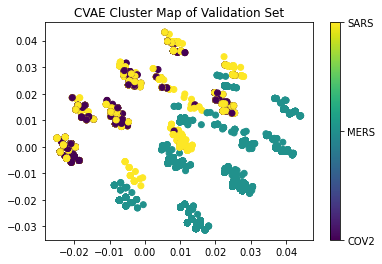

In [16]:
cNorm = matplotlib.colors.Normalize(vmin=min(result), vmax=max(result))
scalarMap = cmx.ScalarMappable(norm=cNorm)
fig = plt.figure(3)
plt.scatter(reduced_val[:, 0], reduced_val[:, 1], c=scalarMap.to_rgba(result))
scalarMap.set_array(result)
cbar = fig.colorbar(scalarMap)
cbar.set_ticks([0,1,2])
cbar.set_ticklabels(["COV2", "MERS", "SARS"])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Cluster Map of Predicted Set')

cNorm = matplotlib.colors.Normalize(vmin=min(label_validation), vmax=max(label_validation))
scalarMap = cmx.ScalarMappable(norm=cNorm)
fig = plt.figure(4)
plt.scatter(reduced_val[:, 0], reduced_val[:, 1], c=scalarMap.to_rgba(label_validation))
scalarMap.set_array(label_validation)
cbar = fig.colorbar(scalarMap)
cbar.set_ticks([0,1,2])
cbar.set_ticklabels(["COV2", "MERS", "SARS"])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Cluster Map of Validation Set')

cNorm = matplotlib.colors.Normalize(vmin=min(labels_val), vmax=max(labels_val))
scalarMap = cmx.ScalarMappable(norm=cNorm)
fig = plt.figure(5)
plt.scatter(reduced_val[:, 0], reduced_val[:, 1], c=scalarMap.to_rgba(labels_val))
scalarMap.set_array(label_validation)
cbar = fig.colorbar(scalarMap)
cbar.set_ticks([0,1,2])
cbar.set_ticklabels(["COV2", "MERS", "SARS"])
plt.title('K-Means Cluster Map of Predicted Set')

cNorm = matplotlib.colors.Normalize(vmin=min(label_validation), vmax=max(label_validation))
scalarMap = cmx.ScalarMappable(norm=cNorm)
fig = plt.figure(6)
plt.scatter(reduced_val[:, 0], reduced_val[:, 1], c=scalarMap.to_rgba(label_validation))
scalarMap.set_array(label_validation)
cbar = fig.colorbar(scalarMap)
cbar.set_ticks([0,1,2])
cbar.set_ticklabels(["COV2", "MERS", "SARS"])
plt.title('K-Means Cluster Map of Validation Set')

cNorm = matplotlib.colors.Normalize(vmin=min(predicted), vmax=max(predicted))
scalarMap = cmx.ScalarMappable(norm=cNorm)
fig = plt.figure(7)
plt.scatter(reduced_val[:, 0], reduced_val[:, 1], c=scalarMap.to_rgba(predicted))
scalarMap.set_array(predicted)
cbar = fig.colorbar(scalarMap)
cbar.set_ticks([0,1,2])
cbar.set_ticklabels(["COV2", "MERS", "SARS"])
plt.title('CAE Cluster Map of Predicted Set')

cNorm = matplotlib.colors.Normalize(vmin=min(label_validation), vmax=max(label_validation))
scalarMap = cmx.ScalarMappable(norm=cNorm)
fig = plt.figure(8)
plt.scatter(reduced_val[:, 0], reduced_val[:, 1], c=scalarMap.to_rgba(label_validation))
scalarMap.set_array(label_validation)
cbar = fig.colorbar(scalarMap)
cbar.set_ticks([0,1,2])
cbar.set_ticklabels(["COV2", "MERS", "SARS"])
plt.title('CAE Cluster Map of Validation Set')

cNorm = matplotlib.colors.Normalize(vmin=min(label_validation), vmax=max(label_validation))
scalarMap = cmx.ScalarMappable(norm=cNorm)
fig = plt.figure(9)
plt.scatter(cvae_embeddings[:, 0], cvae_embeddings[:, 1], c=scalarMap.to_rgba(label_validation))
scalarMap.set_array(label_validation)
cbar = fig.colorbar(scalarMap)
cbar.set_ticks([0,1,2])
cbar.set_ticklabels(["COV2", "MERS", "SARS"])
plt.title('CVAE Cluster Map of Predicted Set')

cNorm = matplotlib.colors.Normalize(vmin=min(label_validation), vmax=max(label_validation))
scalarMap = cmx.ScalarMappable(norm=cNorm)
fig = plt.figure(10)
plt.scatter(reduced_val[:, 0], reduced_val[:, 1], c=scalarMap.to_rgba(label_validation))
scalarMap.set_array(label_validation)
cbar = fig.colorbar(scalarMap)
cbar.set_ticks([0,1,2])
cbar.set_ticklabels(["COV2", "MERS", "SARS"])
plt.title('CVAE Cluster Map of Validation Set')

plt.show()